In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
from random import sample
import json

%matplotlib notebook
%matplotlib inline

In [46]:
crime = pd.read_csv('geoloc_data/NYPD_Arrest_Data_Year_To_Date.csv')
print(len(crime))
crime.head()

214617


,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,206892169,12/31/2019,907.0,"IMPAIRED DRIVING,DRUG",347.0,INTOXICATED & IMPAIRED DRIVING,VTL11920U4,M,M,33,0,25-44,M,WHITE,1000916,245710,40.841085,-73.939769
1,206888084,12/31/2019,739.0,"FRAUD,UNCLASSIFIED-FELONY",112.0,THEFT-FRAUD,PL 1908301,F,Q,101,0,25-44,M,BLACK HISPANIC,1055868,156522,40.596012,-73.742116
2,206890433,12/31/2019,122.0,"HOMICIDE, NEGLIGENT, VEHICLE,",102.0,HOMICIDE-NEGLIGENT-VEHICLE,PL 1251201,F,M,23,0,18-24,M,BLACK,997462,227024,40.789803,-73.952289
3,206890441,12/31/2019,268.0,CRIMINAL MIS 2 & 3,121.0,CRIMINAL MISCHIEF & RELATED OF,PL 1450502,F,S,120,0,18-24,M,BLACK,962822,174282,40.645023,-74.077217
4,206890973,12/31/2019,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,25,97,25-44,M,BLACK,1004138,226326,40.787875,-73.928182


# Pre-Processing

### Drop cols

In [47]:
crime.columns = crime.columns.str.lower()
drop_cols = ['arrest_key', 'pd_cd', 'pd_desc', 'ky_cd', 'law_code', 'jurisdiction_code', 'x_coord_cd', 'y_coord_cd']
crime = crime.drop(drop_cols, axis = 1)
crime.head()

,arrest_date,ofns_desc,law_cat_cd,arrest_boro,arrest_precinct,age_group,perp_sex,perp_race,latitude,longitude
0,12/31/2019,INTOXICATED & IMPAIRED DRIVING,M,M,33,25-44,M,WHITE,40.841085,-73.939769
1,12/31/2019,THEFT-FRAUD,F,Q,101,25-44,M,BLACK HISPANIC,40.596012,-73.742116
2,12/31/2019,HOMICIDE-NEGLIGENT-VEHICLE,F,M,23,18-24,M,BLACK,40.789803,-73.952289
3,12/31/2019,CRIMINAL MISCHIEF & RELATED OF,F,S,120,18-24,M,BLACK,40.645023,-74.077217
4,12/31/2019,ASSAULT 3 & RELATED OFFENSES,M,M,25,25-44,M,BLACK,40.787875,-73.928182


### Extra day, month, year from date

In [48]:
crime['day'] = pd.DatetimeIndex(crime['arrest_date']).day
crime['month'] = pd.DatetimeIndex(crime['arrest_date']).month
crime['year'] = pd.DatetimeIndex(crime['arrest_date']).year
crime.head()

,arrest_date,ofns_desc,law_cat_cd,arrest_boro,arrest_precinct,age_group,perp_sex,perp_race,latitude,longitude,day,month,year
0,12/31/2019,INTOXICATED & IMPAIRED DRIVING,M,M,33,25-44,M,WHITE,40.841085,-73.939769,31,12,2019
1,12/31/2019,THEFT-FRAUD,F,Q,101,25-44,M,BLACK HISPANIC,40.596012,-73.742116,31,12,2019
2,12/31/2019,HOMICIDE-NEGLIGENT-VEHICLE,F,M,23,18-24,M,BLACK,40.789803,-73.952289,31,12,2019
3,12/31/2019,CRIMINAL MISCHIEF & RELATED OF,F,S,120,18-24,M,BLACK,40.645023,-74.077217,31,12,2019
4,12/31/2019,ASSAULT 3 & RELATED OFFENSES,M,M,25,25-44,M,BLACK,40.787875,-73.928182,31,12,2019


### Decode columns

In [49]:
def decode_borough(code):
    dict = {'B': 'Bronx', 'S': 'Staten Island', 'K': 'Brooklyn', 'M': 'Manhattan' , 'Q': 'Queens'}
    return dict[code]

crime['arrest_boro'] = crime['arrest_boro'].apply(decode_borough)


def decode_offence(code):
    dict = {'F': 'Felony','M': 'Misdemeanor', 'V': 'Violation', 'I': 'Other'}
    if code in dict:
        return dict[code]
    else:
        return 'Other'

crime['law_cat_cd'] = crime['law_cat_cd'].apply(decode_offence)
crime.head()

,arrest_date,ofns_desc,law_cat_cd,arrest_boro,arrest_precinct,age_group,perp_sex,perp_race,latitude,longitude,day,month,year
0,12/31/2019,INTOXICATED & IMPAIRED DRIVING,Misdemeanor,Manhattan,33,25-44,M,WHITE,40.841085,-73.939769,31,12,2019
1,12/31/2019,THEFT-FRAUD,Felony,Queens,101,25-44,M,BLACK HISPANIC,40.596012,-73.742116,31,12,2019
2,12/31/2019,HOMICIDE-NEGLIGENT-VEHICLE,Felony,Manhattan,23,18-24,M,BLACK,40.789803,-73.952289,31,12,2019
3,12/31/2019,CRIMINAL MISCHIEF & RELATED OF,Felony,Staten Island,120,18-24,M,BLACK,40.645023,-74.077217,31,12,2019
4,12/31/2019,ASSAULT 3 & RELATED OFFENSES,Misdemeanor,Manhattan,25,25-44,M,BLACK,40.787875,-73.928182,31,12,2019


# Basic Analysis

### Plotting by day of month

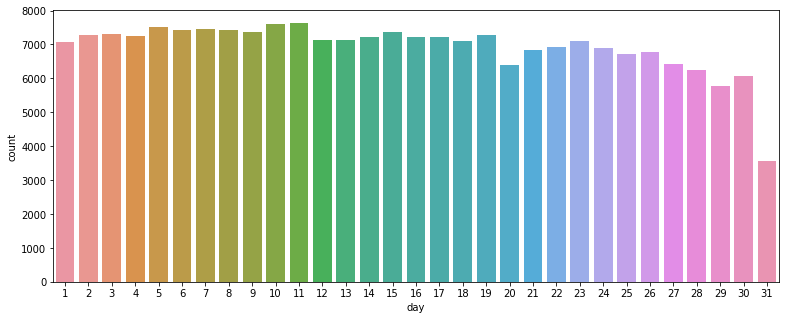

In [51]:
fig = plt.subplots(figsize = (13, 5))
sns.countplot(x = 'day', data = crime)

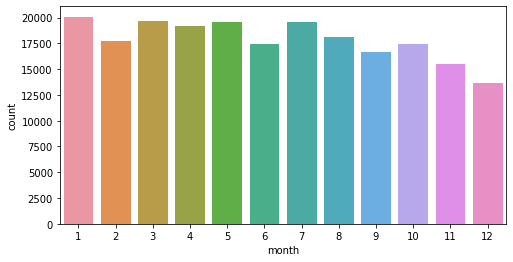

In [52]:
fig = plt.subplots(figsize = (8, 4))
sns.countplot(x = 'month', data = crime)

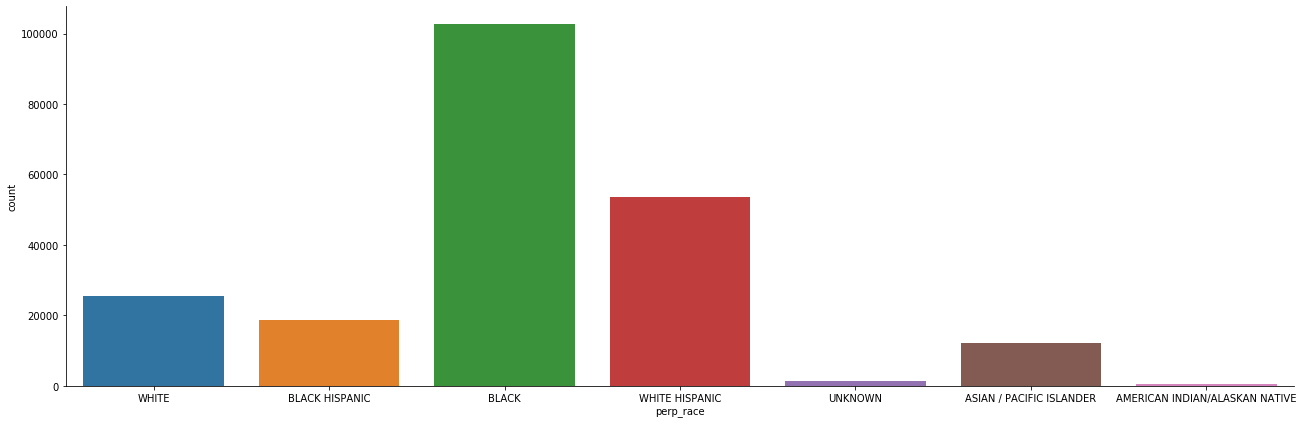

In [53]:
sns.catplot(x = 'perp_race', data = crime, kind = 'count', height = 6, aspect = 3)

# Folium

#### Installation:
#### Using conda (any one):
conda install -c conda-forge folium
<br> conda install -c conda-forge/label/gcc7 folium
<br> conda install -c conda-forge/label/cf201901 folium

#### Using pip:
pip install folium

In [54]:
import folium
from folium.plugins import HeatMap

### Map crimes

In [55]:
positions = list(zip(crime['latitude'], crime['longitude']))
fol = folium.Map(location = [40.75,-73.98], zoom_start = 10, tiles = 'OpenStreetMap')
pos_samp = sample(positions, 25000)
HeatMap(pos_samp, radius = 8).add_to(fol)
fol

### Add markers

In [56]:
fol.add_child(folium.ClickForMarker(popup = 'Potential Location'))

# Geopandas

### Installation:
#### Using conda (Any one):
conda install geopandas 
<br> OR
<br> conda install --channel conda-forge geopandas

#### Using pip:
pip install geopandas

#### Using git:
git clone https://github.com/geopandas/geopandas.git
<br> cd geopandas
<br> pip install .

#### Using GitHub repo:
pip install git+git://github.com/geopandas/geopandas.git


#### Install Descartes:
conda install descartes
<br> OR
<br> pip install descartes

In [57]:
import geopandas

In [58]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
print(len(world))
world.head()

177


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [59]:
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
cities.head()

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Luxembourg,POINT (6.13000 49.61166)
4,Palikir,POINT (158.14997 6.91664)


In [60]:
nyc = geopandas.read_file(geopandas.datasets.get_path('nybb'))
nyc

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [61]:
crime_geo = geopandas.GeoDataFrame(crime, geometry = geopandas.points_from_xy(crime.longitude, crime.latitude))
crime_geo.head()

,arrest_date,ofns_desc,law_cat_cd,arrest_boro,arrest_precinct,age_group,perp_sex,perp_race,latitude,longitude,day,month,year,geometry
0,12/31/2019,INTOXICATED & IMPAIRED DRIVING,Misdemeanor,Manhattan,33,25-44,M,WHITE,40.841085,-73.939769,31,12,2019,POINT (-73.93977 40.84108)
1,12/31/2019,THEFT-FRAUD,Felony,Queens,101,25-44,M,BLACK HISPANIC,40.596012,-73.742116,31,12,2019,POINT (-73.74212 40.59601)
2,12/31/2019,HOMICIDE-NEGLIGENT-VEHICLE,Felony,Manhattan,23,18-24,M,BLACK,40.789803,-73.952289,31,12,2019,POINT (-73.95229 40.78980)
3,12/31/2019,CRIMINAL MISCHIEF & RELATED OF,Felony,Staten Island,120,18-24,M,BLACK,40.645023,-74.077217,31,12,2019,POINT (-74.07722 40.64502)
4,12/31/2019,ASSAULT 3 & RELATED OFFENSES,Misdemeanor,Manhattan,25,25-44,M,BLACK,40.787875,-73.928182,31,12,2019,POINT (-73.92818 40.78787)


<IPython.core.display.Javascript object>


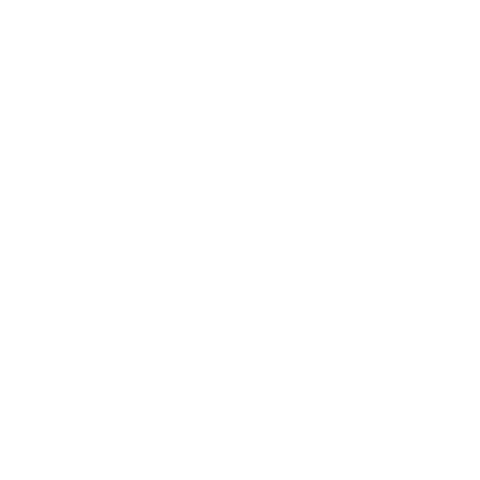

In [62]:
%matplotlib notebook
ax1 = world[world.continent == 'North America'].plot(edgecolor = 'black', figsize = (5, 5))
crime_geo.plot(ax = ax1, column = 'age_group')

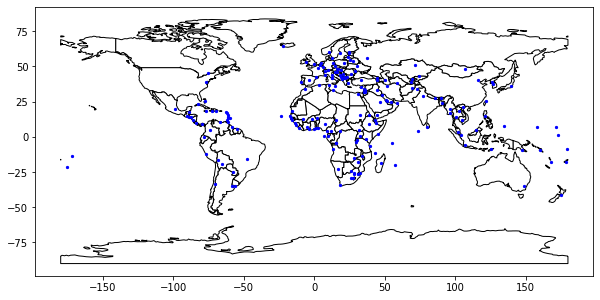

In [63]:
%matplotlib inline
base = world.plot(color = 'white', edgecolor = 'black', figsize = (10, 10))
cities.plot(ax = base, marker = 'o', color = 'blue', markersize = 5);

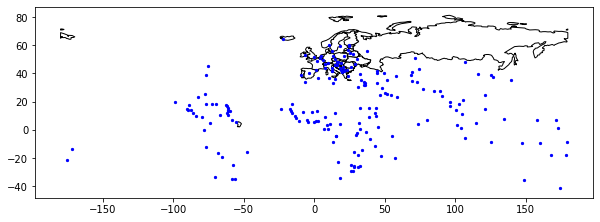

In [64]:
%matplotlib inline
base = world[world.continent == 'Europe'].plot(color = 'white', edgecolor = 'black', figsize = (10, 10))
cities.plot(ax = base, marker = 'o', color = 'blue', markersize = 5);

# Tableau

link: https://www.youtube.com/watch?v=fHe0jFgVPJU